In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tf_utils import delete_summary_dir, fc_layer, compute_cost, save_tensorboard
from alpha import load_data, iterate_minibatches
from tqdm import tqdm as tqdm #For professional progress-bar
from sklearn.preprocessing import LabelEncoder
import datetime, time
from datetime import datetime
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [2]:
inception_pb = './inception_pb/inception.pb'
summary_dir = './summary_log'
bottleneck_file = './bottleneck/Bottle_neck_values.csv'

In [3]:
#IMG_WIDTH, IMG_HEIGHT = [299,299]
N_CHANNELS = 3
N_CLASSES = 2
lr = 0.005

In [4]:
#Get the images
TRAIN_DIR = "./train"
IMG_SIZE = 299 #If changing, change in alpha.py as well
img_shape = (IMG_SIZE,IMG_SIZE,3)
num = 300
train, label= load_data(num, IMG_SIZE, DIR =TRAIN_DIR)
label_df = pd.DataFrame(label, columns = ['classes'])
label_unique = label_df.classes.unique()
en = LabelEncoder()
en.fit(label_df.classes)
encoded_label = en.transform(label_df.classes)
label_df["encoded_label"] = encoded_label
target = (np.arange(2) == encoded_label[:,None]).astype(np.float32)

301it [00:00, 348.69it/s]
301it [00:00, 335.86it/s]


In [5]:
train.shape, target.shape

((600, 299, 299, 3), (600, 2))

In [18]:
#To clear summary directory
delete_summary_dir(summary_dir)

In [19]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="inception")
    return graph

In [20]:
graph = load_graph(inception_pb)

In [21]:
#To view tensor names
#for op in graph.get_operations():
     #print(op.name)

In [22]:
with graph.as_default():
    with tf.variable_scope("transfer"):
        bottleneck = graph.get_tensor_by_name('inception/pool_3:0')#From inception graph
        Y = tf.placeholder(tf.float32, [None, N_CLASSES])
        X = tf.placeholder(tf.float32, [None, 2048])
        #X = bottleneck
        #fc0 = tf.reshape(X,[-1,2048]) #squeeze
        fc1 = fc_layer(X,   2048, 512,  "fc1", activation = 'relu')
        fc2 = fc_layer(fc1, 512,  128,  "fc2", activation = 'relu')
        logits = fc_layer(fc2,   128,  2,     "logits",       activation =  None)
        cost   = compute_cost(logits,Y)
        var = tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope="transfer/") #trainable var_scope
        optimizer = tf.train.AdamOptimizer(learning_rate=lr, name="adam").minimize(cost, var_list=var) #var_list

In [23]:
with tf.Session(graph=graph) as sess:
    filename = "./summary_log/VS-"+time.strftime("%H%M%S")
    writer = tf.summary.FileWriter(filename, sess.graph)
print("Tensorboard summary saved to "+filename) 

Tensorboard summary saved to ./summary_log/VS-102159


In [24]:
var

[<tf.Variable 'transfer/fc1/W:0' shape=(2048, 512) dtype=float32_ref>,
 <tf.Variable 'transfer/fc1/B:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'transfer/fc2/W:0' shape=(512, 128) dtype=float32_ref>,
 <tf.Variable 'transfer/fc2/B:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'transfer/logits/W:0' shape=(128, 2) dtype=float32_ref>,
 <tf.Variable 'transfer/logits/B:0' shape=(2,) dtype=float32_ref>]

In [25]:
def create_bottleneck():
    with tf.Session(graph=graph) as sess:
        im_input = graph.get_tensor_by_name('inception/ExpandDims:0')
        Bottle_neck_values = []
        m = train.shape[0]
        indices = np.arange(m)
        for index in tqdm(range(0, m, 1)): # 1 is when SGD
            batch = indices[index:index + 1]
            Bottle_neck_values.append(sess.run(bottleneck, feed_dict= {im_input:train[batch]}))
        df = pd.DataFrame(np.array(np.squeeze(Bottle_neck_values)))
        df.to_csv("./bottleneck/Bottle_neck_values.csv", index=False)
    return Bottle_neck_values

In [27]:
with tf.Session(graph=graph) as sess:
    #sess.run(tf.variables_initializer(var_list = var, name='init'))
    #writer = tf.summary.FileWriter(filename, sess.graph)
    sess.run(tf.global_variables_initializer())
    if not tf.gfile.Exists(bottleneck_file):
        _ = create_bottleneck()
        print("bottleneck file created")
    
    if tf.gfile.Exists(bottleneck_file):
        bottle_neck = np.array(pd.read_csv("./bottleneck/Bottle_neck_values.csv"))
    minibatch_size = 2
    num_epochs = 5
    for epoch in range(num_epochs):
        avg_cost = 0
        for i, minibatch in enumerate(iterate_minibatches(bottle_neck, target, minibatch_size)):
            (minibatch_X, minibatch_Y) = minibatch
            sess.run(optimizer, feed_dict={X: minibatch_X, Y: minibatch_Y})
            avg_cost += sess.run(cost, feed_dict={X: minibatch_X, Y: minibatch_Y})
            #summ = sess.run(summaryMerged, feed_dict={X: minibatch_X, Y: minibatch_Y})
            #writer.add_summary(summ, i)
        print ("Cost after iteration %i: %f " % (i, avg_cost/(i+1)))
        
        
    print("Training completed!!") #Got out from the loop;
        
    #Save weights
    saver = tf.train.Saver()
    saver.save(sess, "./saved_model/model")

Cost after iteration 299: 0.187450 
Cost after iteration 299: 0.086661 
Cost after iteration 299: 0.000956 
Cost after iteration 299: 0.047338 
Cost after iteration 299: 0.000106 
Training completed!!


In [28]:
bottle_neck.shape

(600, 2048)

In [29]:
bottle_neck = np.array(pd.read_csv("./bottleneck/Bottle_neck_values.csv"))
type(bottle_neck)

numpy.ndarray

In [31]:
transfer_values = bottle_neck

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [33]:
pca = PCA(n_components=2)
transfer_values_reduced = pca.fit_transform(transfer_values)
transfer_values_reduced.shape

(600, 2)

In [34]:
def plot_scatter(values, cls):
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, 2))
    colors = cmap[cls]
    x = values[:, 0]
    y = values[:, 1]
    plt.scatter(x, y, color=colors)
    plt.show()

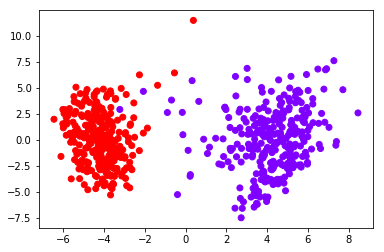

In [35]:
plot_scatter(transfer_values_reduced, encoded_label)

In [36]:
#T-SNE
pca = PCA(n_components=6)
transfer_values_50d = pca.fit_transform(transfer_values)
tsne = TSNE(n_components=2)
transfer_values_reduced = tsne.fit_transform(transfer_values_50d)
transfer_values_reduced.shape

(600, 2)

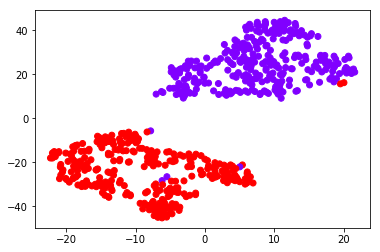

In [37]:
plot_scatter(transfer_values_reduced, encoded_label)